In [1]:
import combinatorial_peptide_pooling as cpp
import pandas as pd
import seaborn as sn
import numpy as np
from math import comb
from matplotlib import pyplot as plt
import time
import tqdm
import pymc as pm
import arviz as az
import random
from scipy import stats

# Algorithm statistics

### Number of pools

In [ ]:
results_time_fixI4 = pd.DataFrame(columns = ['N_pools', '# of peptides', 'Time (s)'])

for n in range(15, 20):
    results_time = dict()
    for i in tqdm.tqdm(range(50, 1000)):
        start_time = time.time()
        b, lines = cpp.address_rearrangement_AU(n_pools=n, iters=4, len_lst=i)
        end_time = time.time()
        elapsed_time = end_time - start_time
        results_time[i] = elapsed_time
    results_time = pd.DataFrame.from_dict(results_time, orient = 'index')
    results_time = results_time.reset_index()
    results_time.columns = ['# of peptides', 'Time (s)']
    results_time['N_pools'] = n
    results_time_fixI4  = pd.concat([results_time_fixI4, results_time])

<Axes: xlabel='# of peptides', ylabel='Time (s)'>

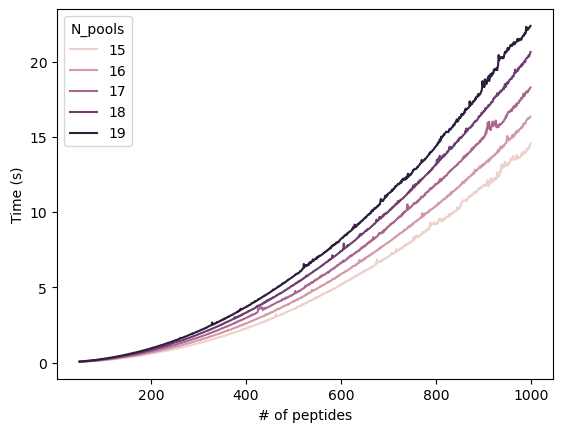

In [2]:
results_time_fix4 = pd.read_csv('running_time_fixI4.tsv',
                               sep = "\t")
sn.lineplot(data = results_time_fix4, x = '# of peptides', y = 'Time (s)', hue = 'N_pools')

### Peptide occurrence

In [ ]:
results_time_fixN20 = pd.DataFrame(columns = ['Iters', '# of peptides', 'Time (s)'])

for iters in range(4, 7):
    results_time = dict()
    for i in tqdm.tqdm(range(50, 1000)):
        start_time = time.time()
        b, lines = cpp.address_rearrangement_AU(n_pools=20, iters=iters, len_lst=i)
        end_time = time.time()
        elapsed_time = end_time - start_time
        results_time[i] = elapsed_time
    results_time = pd.DataFrame.from_dict(results_time, orient = 'index')
    results_time = results_time.reset_index()
    results_time.columns = ['# of peptides', 'Time (s)']
    results_time['Iters'] = iters
    results_time_fixN20  = pd.concat([results_time_fixN20, results_time])

<Axes: xlabel='# of peptides', ylabel='Time (s)'>

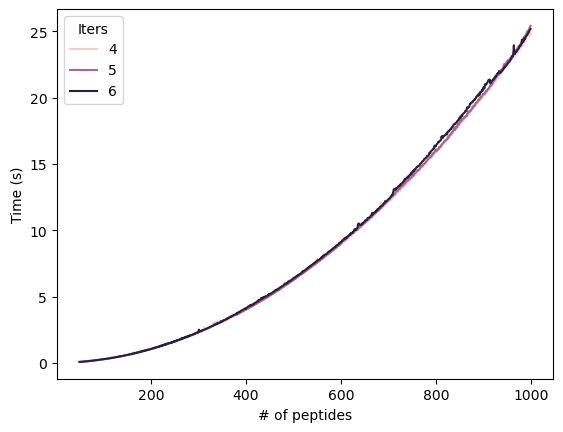

In [3]:
results_time_fixN20 = pd.read_csv('/Users/hmeyer/peptide_pooling/for_paper/analyses/running_time_fixN20.tsv',
                               sep = "\t")
sn.lineplot(data = results_time_fixN20, x = '# of peptides', y = 'Time (s)', hue = 'Iters')

### Balance

In [4]:
results_balance_fixN16_fixI4 = dict()
for i in tqdm.tqdm(range(50, 1000, 100)):
    b, lines = cpp.address_rearrangement_AU(n_pools=16, iters=4, len_lst=i)
    results_balance_fixN16_fixI4[i] = b
    
balance = pd.DataFrame.from_dict(results_balance_fixN16_fixI4, orient = 'index')    
balance['perfect'] = 0
for i in list(balance.index):
    balance['perfect'].loc[i] = int(i*4/16)
    
for i in list(balance.index):
    for y in balance.columns:
        if y != 'perfect':
            balance[y].loc[i] = balance[y].loc[i] - balance['perfect'].loc[i]

100%|███████████████████████████████████████████| 10/10 [00:54<00:00,  5.45s/it]


In [5]:
balance

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,perfect
50,0,2,0,0,-1,0,0,1,0,1,0,3,0,2,0,0,12
150,0,-1,1,1,-1,-1,0,1,4,1,0,-1,4,0,1,-1,37
250,1,-1,2,-2,1,-1,1,1,0,0,4,0,1,0,0,1,62
350,0,-2,-1,-2,0,-2,1,0,0,0,3,3,3,2,1,2,87
450,-2,-1,3,0,-2,2,-1,4,-1,0,1,3,-2,1,0,3,112
550,-1,1,1,1,1,1,-1,-3,1,-1,-1,3,1,0,3,2,137
650,1,1,3,0,0,0,-2,1,-1,0,2,-1,0,3,0,1,162
750,3,-2,0,0,0,-2,0,0,5,3,2,3,-4,0,1,-1,187
850,3,2,-1,1,-1,-2,0,0,2,-1,-1,0,1,-1,2,4,212
950,0,2,1,3,-4,0,-1,3,-1,1,0,-3,5,0,3,-1,237


Text(0, 0.5, 'Balance_perfect - Balance_actual')

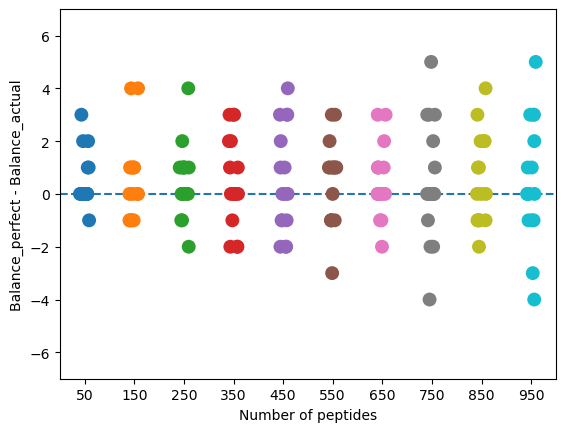

In [6]:
plot = sn.stripplot(data = balance.drop('perfect', axis=1).T, jitter = 0.1, size = 10)
plot.axhline(0, ls='--')
plot.set_ylim(-7, 7)
plot.set_xlabel('Number of peptides')
plot.set_ylabel('Balance_perfect - Balance_actual')

### Errors

In [ ]:
def random_amino_acid_sequence(length):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    return ''.join(random.choice(amino_acids) for _ in range(length))

length = 2000
sequence = random_amino_acid_sequence(length)
lst_all = []
for i in range(0, len(sequence), 5):
    ps = sequence[i:i+17]
    if len(ps) == 17:
        lst_all.append(ps)

n_pools = 18
iters = 6
simulation_results_fixN18_fixI6 = pd.DataFrame(columns = ['Peptide', 'Address', 'Epitope', 'Act Pools',
                                        '# of pools', '# of epitopes', '# of peptides', 'Remained', '# of lost',
                                           'Right peptide', 'Right epitope', 'Len'])

for i in tqdm.tqdm(range(100, 400, 100)):

    b, lines = cpp.address_rearrangement_AU(n_pools=n_pools, iters=iters, len_lst=i)
    lst = lst_all[:i]
    pools, peptide_address = cpp.pooling(lst=lst, addresses=lines, n_pools=n_pools)
    check_results = cpp.run_experiment(lst=lst, peptide_address=peptide_address, ep_length=8,
                              pools=pools, iters=iters, n_pools=n_pools, regime='with dropouts')
    check_results['Len'] = i
    simulation_results_fixN18_fixI6 = pd.concat([simulation_results_fixN18_fixI6, check_results])

In [7]:
simulation_results_fixN18_fixI6 = pd.read_csv('simulation_fixN18_fixI6.tsv', sep = "\t")
simulation_results_fixN18_fixI6

,Peptide,Address,Epitope,Act Pools,# of pools,# of epitopes,# of peptides,Remained,# of lost,Right peptide,Right epitope,Len
0,DSKGRCMENPIFIFFLA,"[0, 1, 2, 3, 4, 5]",DSKGRCME,"[0, 1, 2, 3, 4, 5]",6,200,47,[0],5,True,False,100
1,DSKGRCMENPIFIFFLA,"[0, 1, 2, 3, 4, 5]",DSKGRCME,"[0, 1, 2, 3, 4, 5]",6,205,47,[1],5,True,False,100
2,DSKGRCMENPIFIFFLA,"[0, 1, 2, 3, 4, 5]",DSKGRCME,"[0, 1, 2, 3, 4, 5]",6,190,44,[2],5,True,False,100
3,DSKGRCMENPIFIFFLA,"[0, 1, 2, 3, 4, 5]",DSKGRCME,"[0, 1, 2, 3, 4, 5]",6,205,47,[3],5,True,False,100
4,DSKGRCMENPIFIFFLA,"[0, 1, 2, 3, 4, 5]",DSKGRCME,"[0, 1, 2, 3, 4, 5]",6,175,40,[4],5,True,False,100
...,...,...,...,...,...,...,...,...,...,...,...,...
760075,RGTGVRRKHYAMDKDCW,"[4, 5, 6, 7, 10, 15]",YAMDKDCW,"[4, 5, 6, 7, 10, 15]",6,20,7,"[4, 5, 6, 10, 15]",1,True,False,300
760076,RGTGVRRKHYAMDKDCW,"[4, 5, 6, 7, 10, 15]",YAMDKDCW,"[4, 5, 6, 7, 10, 15]",6,10,3,"[4, 5, 7, 10, 15]",1,True,False,300
760077,RGTGVRRKHYAMDKDCW,"[4, 5, 6, 7, 10, 15]",YAMDKDCW,"[4, 5, 6, 7, 10, 15]",6,15,5,"[4, 6, 7, 10, 15]",1,True,False,300
760078,RGTGVRRKHYAMDKDCW,"[4, 5, 6, 7, 10, 15]",YAMDKDCW,"[4, 5, 6, 7, 10, 15]",6,5,2,"[5, 6, 7, 10, 15]",1,True,False,300


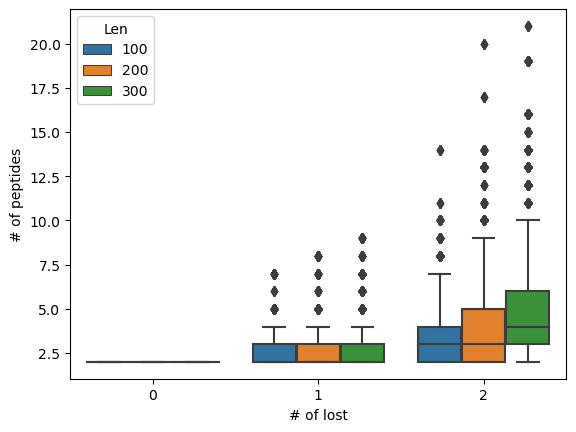

In [8]:
ax = sn.boxplot(data = simulation_results_fixN18_fixI6[simulation_results_fixN18_fixI6['# of lost'] < 3],
                x = '# of lost', y = '# of peptides', hue = 'Len')

### Number of pools - Peptide occurrence - Number of peptides

In [9]:
data = pd.DataFrame(columns = ['N_pools', 'Peptide occurrence', '# of peptides'])

for n in tqdm.tqdm(range(8, 13)):
    for i in range(2, 12):
        row = pd.DataFrame({'N_pools':n, 'Peptide occurrence':i, '# of peptides':comb(n, i)}, index=[0])
        data = pd.concat([data, row])

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 300.43it/s]


<Axes: xlabel='Peptide occurrence', ylabel='# of peptides'>

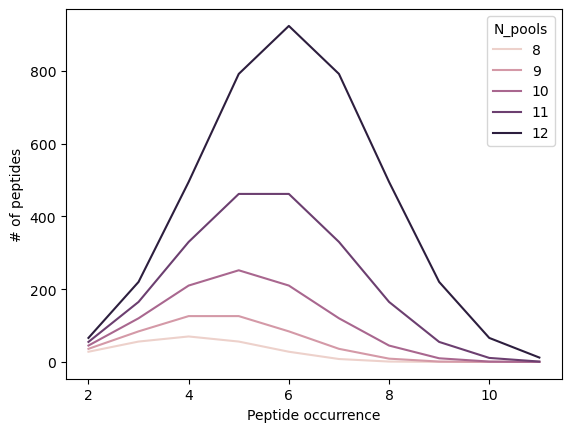

In [10]:
sn.lineplot(data = data, x='Peptide occurrence', y='# of peptides', hue = 'N_pools')

# Experiment results

### Flow cytometry

/var/folders/bb/6j1bt4dj4x15t9jtm7vlh6gh0000gp/T/ipykernel_70351/1699718621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['well_type'][results['well_type'] == 'allmix_5x_dilution'] = 'allmix_5x'
/var/folders/bb/6j1bt4dj4x15t9jtm7vlh6gh0000gp/T/ipykernel_70351/1699718621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['well_type'][results['well_type'] == 'allmix_25x_dilution'] = 'allmix_25x'


Text(0.5, 0, '')

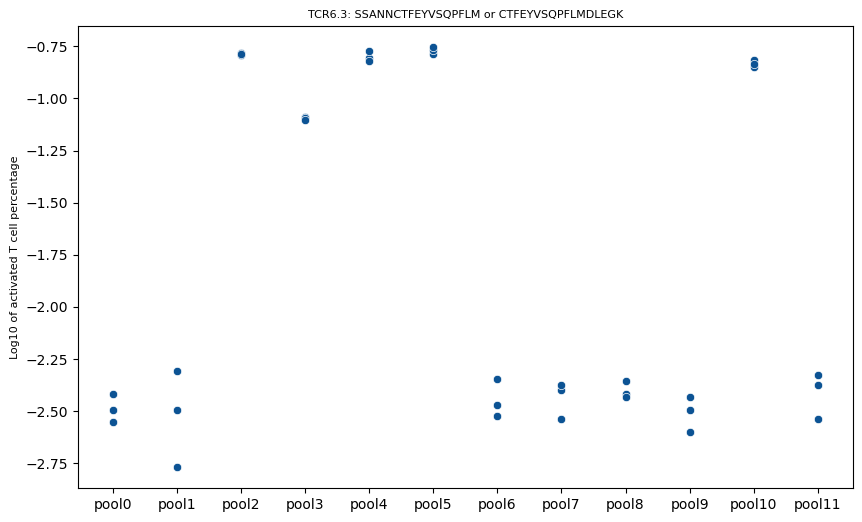

In [11]:
results = pd.read_excel('flow_results.xlsx')
results['well_type'][results['well_type'] == 'allmix_5x_dilution'] = 'allmix_5x'
results['well_type'][results['well_type'] == 'allmix_25x_dilution'] = 'allmix_25x'

results['GFPpos_of_Jurkat_perc_log10'] = np.log10(results['GFPpos_of_Jurkat_perc']/100)
results['GFPpos_of_Jurkat_perc_ln'] = np.log(results['GFPpos_of_Jurkat_perc']/100)

plt.figure(figsize=(10, 6))
ax = sn.scatterplot(data = results[results['well_type'].str.contains('pool')],
                   x = 'well_type', y = 'GFPpos_of_Jurkat_perc_log10', color = '#0c5394')
plt.ylabel('Log10 of activated T cell percentage', fontsize=8)
ax.set_title('TCR6.3: SSANNCTFEYVSQPFLM or CTFEYVSQPFLMDLEGK', fontsize=8)
ax.set_ylabel('Log10 of activated T cell percentage', fontsize=8)
ax.set_xlabel('', fontsize=14)

### Microscopy

Text(0.5, 0, '')

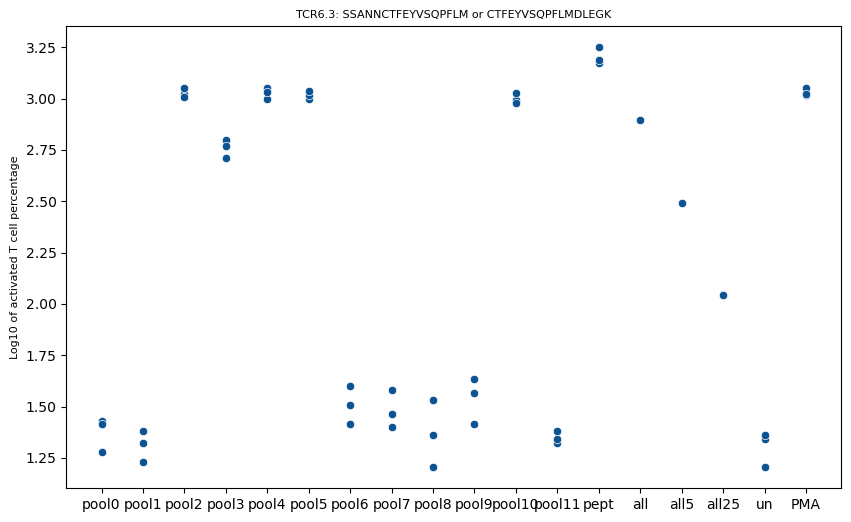

In [12]:
incu = pd.read_csv('incucyte_results.txt', sep = "\t",
                   index_col = 0)
cell_i = np.log10(list(incu.loc['E'].values) + list(incu.loc['F'].values) + list(incu.loc['G'].values) + list(incu.loc['H'].values))
inds = ['pool0', 'pool1', 'pool2', 'pool3', 'pool4', 'pool5',
        'pool6','pool7', 'pool8', 'pool9', 'pool10', 'pool11',
        'pool0', 'pool1', 'pool2', 'pool3', 'pool4', 'pool5',
        'pool6', 'pool7', 'pool8', 'pool9', 'pool10', 'pool11',
        'pool0', 'pool1', 'pool2', 'pool3', 'pool4', 'pool5',
        'pool6', 'pool7', 'pool8', 'pool9', 'pool10', 'pool11',
       'pept', 'pept', 'pept', 'all', 'all5', 'all25', 'un', 'un', 'un', 'PMA', 'PMA', 'PMA']
incu = pd.DataFrame(columns = ['Pool', 'Value'])
incu['Pool'] = inds
incu['Value'] = cell_i

plt.figure(figsize=(10, 6))
ax = sn.scatterplot(data = incu,
                   x = 'Pool', y = 'Value', color = '#0c5394')
plt.ylabel('Log10 of activated T cell percentage', fontsize=8)
ax.set_title('TCR6.3: SSANNCTFEYVSQPFLM or CTFEYVSQPFLMDLEGK', fontsize=8)
ax.set_ylabel('Log10 of activated T cell percentage', fontsize=8)
ax.set_xlabel('', fontsize=14)

### Flow cytometry VS Microscopy

Text(0.5, 0, 'Log10 of activated T cell percentage (flow cytometry)')

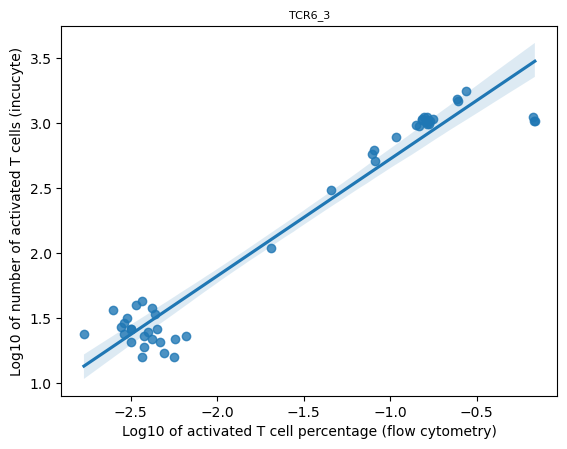

In [13]:
incu = pd.read_csv('incucyte_results.txt', sep = "\t",
                   index_col = 0)
cell_i = np.log10(list(incu.loc['E'].values) + list(incu.loc['F'].values) + list(incu.loc['G'].values) + list(incu.loc['H'].values))
cell_f = list(results['GFPpos_of_Jurkat_perc_log10'][(results['Cell_line'] == 'TCR6_3')])
ax = sn.regplot(x = cell_f, y = cell_i)
ax.set_title('TCR6_3', fontsize=8)
ax.set_ylabel('Log10 of number of activated T cells (incucyte)')
ax.set_xlabel('Log10 of activated T cell percentage (flow cytometry)')

In [14]:
slope, intercept, r_value, p_value, std_err = stats.linregress(cell_f, cell_i)
r_squared = r_value**2
print(round(r_squared, 2))

0.94


# Model

In [15]:
# Data
## Flow cytometry
results = pd.read_excel('flow_results.xlsx')
cell_f = list(results['GFPpos_of_Jurkat_perc'][(results['Cell_line'].str.contains('TCR6_3'))
                                 & (results['well_type'].str.contains('pool'))])
## Microscopy
incu = pd.read_csv('incucyte_results.txt', sep = "\t",
                   index_col = 0)
cell_i = list(incu.loc['E'].values) + list(incu.loc['F'].values) + list(incu.loc['G'].values)
cell_i = cell_i/sum(cell_i)*100

## Indices
inds = inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
               0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
               0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

### Flow cytometry

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [source, sigma, pool_dist, sigma_data]
>BinaryGibbsMetropolis: [assign]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


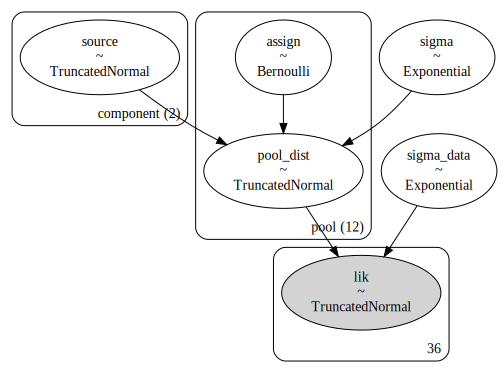

In [16]:
coords = dict(pool=range(12), component=("positive", "negative"))

with pm.Model(coords=coords) as alternative_model:
    # 2 normal 'source' distributions for the positive and negative pools
    source = pm.TruncatedNormal(
        "source",
        mu=np.array([10, 0.5]),
        sigma=np.array([0.5, 0.1]),
        dims="component",
        lower=0,
    )

    # Each pool is assigned a 0/1 (could adjust the prior probability here given that we
    # know negatives are more likely a priori)
    component = pm.Bernoulli("assign", 0.5, dims="pool")

    # Each pool has a normally distributed response whose mu comes from either the
    # postive or negative source distribution
    pool_dist = pm.TruncatedNormal(
        "pool_dist",
        mu=source[component],
        sigma=pm.Exponential("sigma", 1),
        lower=0,
        dims="pool",
    )

    # Likelihood, where the data indices pick out the relevant pool from pool
    pm.TruncatedNormal(
        "lik",
        mu=pool_dist[inds],
        sigma=pm.Exponential("sigma_data", 1),
        observed=cell_f,
        lower=0,
    )

    idata_alt = pm.sample()

pm.model_to_graphviz(alternative_model)

Sampling: [lik]


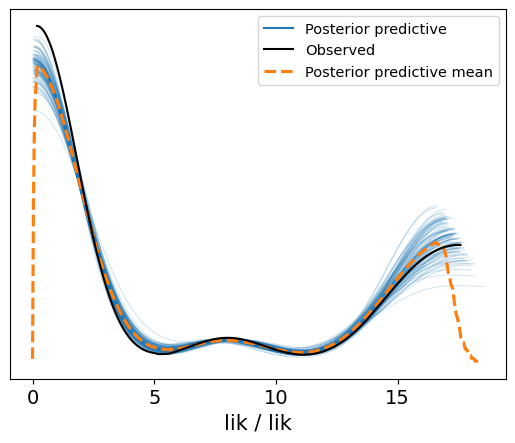

In [17]:
with alternative_model:
    posterior_predictive = pm.sample_posterior_predictive(idata_alt)

ax = az.plot_ppc(posterior_predictive, num_pp_samples=100)

In [18]:
posterior = az.extract(idata_alt)
print(posterior["assign"].mean(dim="sample").to_dataframe())

       assign
pool         
0     0.98075
1     0.97825
2     0.00550
3     0.19300
4     0.00800
5     0.00800
6     0.97925
7     0.97775
8     0.97975
9     0.97800
10    0.01300
11    0.98200


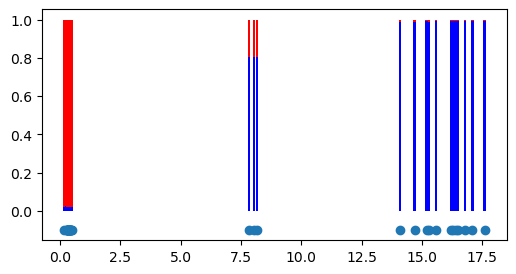

In [19]:
idx = list(posterior["assign"].mean(dim="sample").to_dataframe()['assign'])*3
probs = pd.DataFrame(columns = ['Probs'])
probs['Probs'] = idx

_, ax = plt.subplots(figsize=(6, 3))
ax.bar(cell_f, 1-probs['Probs'], width=0.1, label="idx==0", color="b")
ax.bar(cell_f, probs['Probs'], bottom=1-probs['Probs'], width=0.1, label="idx==1", color="r")
ax.scatter(cell_f, [-0.1]*36)

### Microscopy

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [source, sigma, pool_dist, sigma_data]
>BinaryGibbsMetropolis: [assign]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
/Users/hmeyer/anaconda3/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


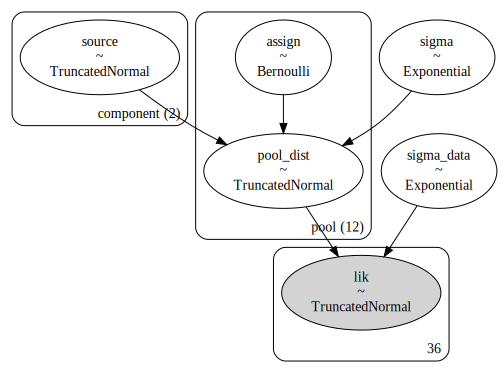

In [20]:
coords = dict(pool=range(12), component=("positive", "negative"))

with pm.Model(coords=coords) as alternative_model:
    # 2 normal 'source' distributions for the positive and negative pools
    source = pm.TruncatedNormal(
        "source",
        mu=np.array([6, 0.5]),
        sigma=np.array([0.5, 0.1]),
        dims="component",
        lower=0,
    )

    # Each pool is assigned a 0/1 (could adjust the prior probability here given that we
    # know negatives are more likely a priori)
    component = pm.Bernoulli("assign", 0.5, dims="pool")

    # Each pool has a normally distributed response whose mu comes from either the
    # postive or negative source distribution
    pool_dist = pm.TruncatedNormal(
        "pool_dist",
        mu=source[component],
        sigma=pm.Exponential("sigma", 1),
        lower=0,
        dims="pool",
    )

    # Likelihood, where the data indices pick out the relevant pool from pool
    pm.TruncatedNormal(
        "lik",
        mu=pool_dist[inds],
        sigma=pm.Exponential("sigma_data", 1),
        observed=cell_i,
        lower=0,
    )

    idata_alt = pm.sample()

pm.model_to_graphviz(alternative_model)

Sampling: [lik]


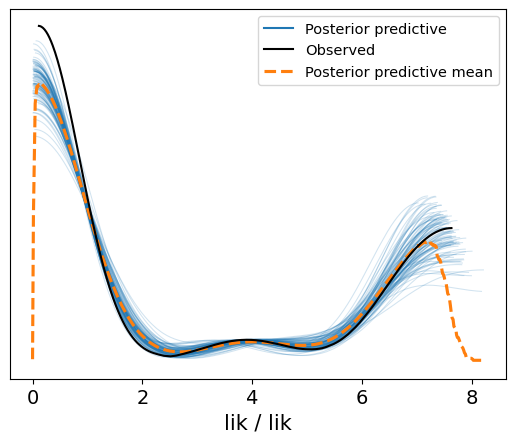

In [21]:
with alternative_model:
    posterior_predictive = pm.sample_posterior_predictive(idata_alt)

ax = az.plot_ppc(posterior_predictive, num_pp_samples=100)

In [22]:
posterior = az.extract(idata_alt)
print(posterior["assign"].mean(dim="sample").to_dataframe())

       assign
pool         
0     0.99925
1     0.99950
2     0.00025
3     0.12675
4     0.00050
5     0.00000
6     1.00000
7     0.99975
8     0.99975
9     1.00000
10    0.00075
11    1.00000


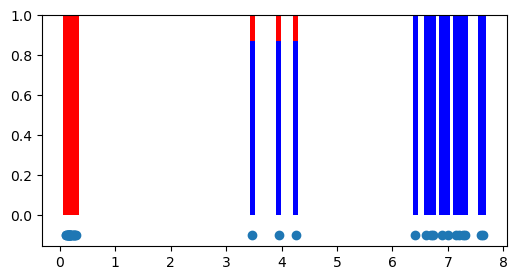

In [23]:
idx = list(posterior["assign"].mean(dim="sample").to_dataframe()['assign'])*3
probs = pd.DataFrame(columns = ['Probs'])
probs['Probs'] = idx

_, ax = plt.subplots(figsize=(6, 3))
ax.bar(cell_i, 1-probs['Probs'], width=0.1, label="idx==0", color="b")
ax.bar(cell_i, probs['Probs'], bottom=1-probs['Probs'], width=0.1, label="idx==1", color="r")
ax.scatter(cell_i, [-0.1]*36)